# Select suitable MDL test

# Purpose
Find suitable roll decay tests from MDL, to reproduce in Motions later on.

# Methodology
Look at the results from the KLVCC2 ship.
* Load model tests from MDL
* Determine damping
* Predict with
    * SI
    * Ikeda

# WIP - improvements
(WORK IN PROGRESS)
Use this section only if the notebook is not final.

Notable TODOs:
* todo 1
* todo 2
* todo 3

## Results
Describe and comment the most important results.

# Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

In [1]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
#plt.style.use('paper')

#import data
import copy
from mdldb.tables import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
from mdldb.hdf5_file import Hdf5File

In [3]:
db = database.get_db()

In [66]:
sql = """
SELECT * from run
WHERE model_number='M5057-01-A' and test_type='roll decay' and project_number=40178362;
"""
df_rolldecays = pd.read_sql(sql=sql, con=db.engine, index_col='id')

df_rolldecays['ship_speed'].fillna(0, inplace=True)


In [67]:
df_rolldecays

,project_number,series_number,run_number,test_number,model_number,ship_name,loading_condition_id,ascii_name,ship_speed,comment,file_path_ascii,file_path_ascii_temp,file_path_log,file_path_hdf5,date,test_type,facility,angle1,angle2,Körfallstyp
id,,,,,,,,,,,,,,,,,,,,
21337,40178362,1,94,1,M5057-01-A,M5057-01-A,166,94.0,0.0,"Roll decay, 0 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-03,roll decay,MDL,None,None,None
21338,40178362,1,95,1,M5057-01-A,M5057-01-A,166,95.0,0.0,"Roll decay, 0 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-03,roll decay,MDL,None,None,None
21339,40178362,1,96,1,M5057-01-A,M5057-01-A,166,96.0,0.0,"Roll decay, 0 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-11-28,roll decay,MDL,None,None,None
21340,40178362,1,97,1,M5057-01-A,M5057-01-A,166,97.0,15.5,"Roll decay, 15.5 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-04,roll decay,MDL,None,None,None


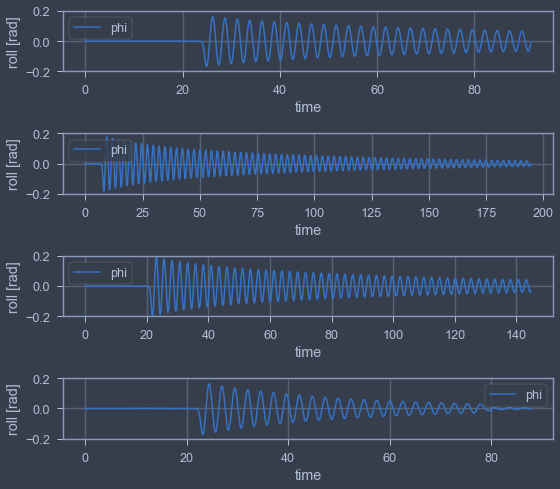

In [74]:
fig,axes=plt.subplots(nrows=len(df_rolldecays))

for (id, row),ax in zip(df_rolldecays.iterrows(),axes):

    db_run = db.session.query(tables.Run).get(int(id))
    df,units = database.load_run(db_run, save_as_example=False, prefer_hdf5=True)
    
    df.plot(y='phi', ax=ax)
    ax.set_ylabel(f"roll [{units['phi']}]")
    ax.grid(True)
    ax.set_ylim([-0.2,0.2])

plt.tight_layout()

In [69]:
df.head()

,ap/amplitud,ap/cirkelorder,ap/execute,ap/kurs,ap/kursorder,ap/mode,ap/order,ap/pullout,ap/rodergrundvinkel,ap/wait,ap/zzamplitud,ap/zzorder,arr/cmd/arr,arr/cmd/fri,arr/ind/arr,arr/ind/fri,carriage/course,carriage/elaxel,carriage/psip,carriage/speed,carriage/xp,carriage/xp_east,carriage/xp_west,carriage/yp,carriage/zp,carriage/dxp,filter/kurs/kurs,filter/rpm/length,filter/rpm/rpm,hull/acc/x1,hull/acc/y1,hull/acc/y2,hull/acc/z1,hull/acc/z2,hull/acc/z3,kb/apgamma,kb/apsigma,kb/scalefactor,ma/alfa,ma/beta,ma/connected,ma/delta,ma/gamma,theta,phi,ma/torkorr,mops/abb/in/stat1,mops/abb/in/stat2,mops/abb/in/bit0,mops/abb/in/bit1,mops/abb/in/bit2,mops/abb/out/stat1,mops/abb/out/stat2,mops/proj,mops/run,mops/ser,mops/test,mops/watchdog,mops/logtrig,mops/relt,modelpos/cog,modelpos/knotsfs,modelpos/pitchm,modelpos/psidiff,modelpos/rollm,modelpos/sog,modelpos/xdiff,modelpos/xm,modelpos/yawm,modelpos/yawrate,modelpos/ydiff,modelpos/ym,modelpos/zm,prop/rpm,prop/thrust,prop/torque,rudder/angle,rudder/rate,rudder/roderorder,zmq/pos/msgtyp,zmq/video/msgtyp,lab/waveheight
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,0.174533,0.013963,0.0,0.0,0.013963,0.0,0.013963,NaN,0.013963,NaN,0.0,0.013963,NaN,NaN,1.0,0.0,0.0,-0.003,0.000698,0.0,-31.998,-31.997,-32.0,0.0,0.171,0.0,0.000873,250.0,13.030414,0.011302,0.026227,-0.011039,0.047819,0.012569,-0.079930,2.0,0.8,68.0,0.000436,0.001309,1.0,0.000262,0.000436,0.000349,-0.000611,0.0,0.0,28.0,0.0,0.0,0.0,NaN,NaN,40178362.0,1.0,1.0,5.0,12.0,1.0,22532.279990,0.0,0.007,0.000349,0.000175,-0.000611,0.000437,0.000872,-31.997628,0.000873,0.0,0.000437,0.000437,0.000436,13.103137,22.363865,-0.338089,0.014483,19.13,0.013963,1003.0,1002.0,-0.355356
0.010000,0.174533,0.013963,0.0,0.0,0.013963,0.0,0.013963,NaN,0.013963,NaN,0.0,0.013963,NaN,NaN,1.0,0.0,0.0,-0.003,0.000698,0.0,-31.998,-31.997,-32.0,0.0,0.171,0.0,0.000873,250.0,13.031233,0.057751,-0.069204,0.074859,0.037505,-0.060331,-0.020003,2.0,0.8,68.0,0.000436,0.001309,1.0,0.000262,0.000436,0.000175,-0.000611,0.0,0.0,28.0,0.0,0.0,0.0,NaN,NaN,40178362.0,1.0,1.0,5.0,12.0,1.0,22532.289989,0.0,0.007,0.000175,0.000175,-0.000611,0.000437,0.000872,-31.997628,0.000873,0.0,0.000437,0.000437,0.000436,13.133425,22.537338,-0.324991,0.014028,19.13,0.013963,1003.0,1002.0,-0.355356
0.019992,0.174533,0.013963,0.0,0.0,0.013963,0.0,0.013963,NaN,0.013963,NaN,0.0,0.013963,NaN,NaN,1.0,0.0,0.0,-0.003,0.000698,0.0,-31.998,-31.997,-32.0,0.0,0.171,0.0,0.000873,250.0,13.031654,-0.059663,0.056533,-0.110501,-0.075952,0.060954,0.095340,2.0,0.8,68.0,0.000436,0.001309,1.0,0.000262,0.000436,0.000349,-0.000611,0.0,0.0,28.0,0.0,0.0,0.0,NaN,NaN,40178362.0,1.0,1.0,5.0,14.0,1.0,22532.299982,0.0,0.007,0.000349,0.000175,-0.000611,0.000437,0.000872,-31.997628,0.000873,0.0,0.000437,0.000437,0.000436,13.053263,22.493858,-0.325556,0.014301,19.13,0.013963,1003.0,1002.0,-0.355356
0.029990,0.174533,0.013963,0.0,0.0,0.013963,0.0,0.013963,NaN,0.013963,NaN,0.0,0.013963,NaN,NaN,1.0,0.0,0.0,-0.003,0.000698,0.0,-31.998,-31.997,-32.0,0.0,0.171,0.0,0.000873,250.0,13.031619,-0.043534,-0.022778,0.003815,0.002050,-0.013881,0.009638,2.0,0.8,68.0,0.000436,0.001309,1.0,0.000262,0.000436,0.000262,-0.000611,0.0,0.0,28.0,0.0,0.0,0.0,NaN,NaN,40178362.0,1.0,1.0,5.0,15.0,1.0,22532.309980,0.0,0.007,0.000262,0.000175,-0.000611,0.000437,0.000872,-31.997628,0.000873,0.0,0.000437,0.000437,0.000436,13.022258,22.364084,-0.336800,0.014438,19.13,0.013963,1003.0,1002.0,-0.355356
0.039990,0.174533,0.013963,0.0,0.0,0.013963,0.0,0.013963,NaN,0.013963,NaN,0.0,0.013963,NaN,NaN,1.0,0.0,0.0,-0.003,0.000698,0.0,-31.998,-31.997,-32.0,0.0,0.171,0.0,0.000873,250.0,13.030953,0.099039,0.125527,0.122652,-0.091423,-0.055170,0.085030,2.0,0.8,68.0,0.000436,0.001309,1.0,0.000262,0.000436,0.000349,-0.000611,0.0,0.0,28.0,0.0,0.0,0.0,NaN,NaN,40178362.0,1.0,1.0,5.0,1.0,1.0,22532.319980,0.0,0.007,0.000349,0.000175,-0.000611,0.000437,0.000872,-31.997628,0.000873,0.0,0.000437,0.000437,0.000436,12.923704,22.073596,-0.

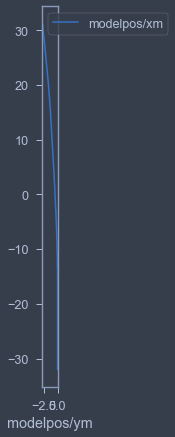

In [73]:
fig,ax=plt.subplots()
df.plot(x = 'modelpos/ym', y='modelpos/xm', ax=ax)
ax.set_aspect('equal')